# Project 3 - Classifying Reddit Comments

### Problem Statement

Given the rise in adoption of OTT streaming services, and the launch of newer players in 2019 (e.g. HBO GO, Disney+), the CEO of Netflix is interested in understanding feedback on their streaming service through going through forums where consumers actively discuss the pros and cons of each streaming service, such as the Cordcutters Forum - https://forums.cordcutters.com. However the forums are often not sorted/classified well, and it is time consuming to go through each comment before understanding which streaming service the consumer is referring to. In order to solve this problem, I have decided to train a model to understand what are the key words in comments/posts that consumers typically mention when referring to Netflix through using subreddits /r/netflix and contrast it to /r/hulu, which is the largest competitor of Netflix at this point in time.


### Executive Summary

The model chosen is the Logistic Regression model with a TFIFD vectorizer, which allows a maximum number of 3000 features, and a combination of up to 3 words. This model has been verified to be quite effective at classifying between two subreddits (I had tested the model on two other subreddits /r/MakeupAddiction and /r/SkincareAddiction which are also close in terms of word frequency and terminology and have achieved a great score of 98%) and had achieved an accuracy score of ~93%.

Interesting features to note is that Netflix comments are mostly distinguished through titles of popular shows (e.g. Stranger Things) however what distinguishes Hulu comments are its features (e.g. Live TV, DVR, Commercials).

## 1. Importing Data

In order to scrape the data from the subreddits /r/netflix and /r/hulu, I have created a scraping function that I have stored in another notebook labeled Subreddit Scraping Function. I have not cleaned any of the data that has been scraped, apart from narrowing down the data to only include 1 post per Reddit ID.

In [392]:
#import necessary libraries
import requests
import json
import pandas as pd
import requests
import time
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize 
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import regex as re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download('punkt')

%config InlineBackend.figure_format = 'retina'


[nltk_data] Downloading package punkt to /Users/lynn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [393]:
#Preparing the dataframes
netflix = pd.read_csv('netflix.csv')  #importing Netflix data
hulu = pd.read_csv('hulu.csv') #importing Hulu data

In [394]:
netflix.shape

(4128, 104)

In [395]:
hulu.shape

(3309, 107)

In [396]:
pd.set_option('display.max_columns',500) #viewing all columns
print(netflix.head()) #view first 5 rows to understand dataset
print ('Columns:', len(netflix.columns))

   Unnamed: 0                                      all_awardings  \
0           0                                                 []   
1           1                                                 []   
2           2  [{'count': 1, 'is_enabled': True, 'subreddit_i...   
3           3                                                 []   
4           4                                                 []   

   allow_live_comments  approved_at_utc  approved_by  archived         author  \
0                 True              NaN          NaN     False      Elainasha   
1                 True              NaN          NaN     False  FPS_Yusuf1999   
2                False              NaN          NaN     False       infodawg   
3                False              NaN          NaN     False  ThisisWiretap   
4                False              NaN          NaN     False     maskedhero   

   author_cakeday author_flair_background_color  author_flair_css_class  \
0             NaN            

In [397]:
#Create a column that includes only relevant texts that we want to keep (e.g. Title, Self Text) for Netflix Data
netflix['selftext'].fillna('', inplace=True) #fills empty cells with a space to allow concatenation in the next step
netflix['all_txt'] = netflix['title']+netflix['selftext'] # joining together two columns for analysis
netflix['all_txt'].isnull().sum() #ensuring there is no null values

0

In [398]:
netflix[['selftext', 'title','all_txt']].head()

,selftext,title,all_txt
0,New Netflix Originals|Genre|Release ...,List of some upcoming new Netflix Original ser...,List of some upcoming new Netflix Original ser...
1,,Stranger Things 4 | Official Announcement,Stranger Things 4 | Official Announcement
2,I'm a native English speaker and I won't watch...,Anyone else addicted to subtitles?,Anyone else addicted to subtitles?I'm a native...
3,,"Netflix Q3 earnings exceed estimates, despite ...","Netflix Q3 earnings exceed estimates, despite ..."
4,,Atypical Season 3 Trailer,Atypical Season 3 Trailer


In [399]:
#Create a column that includes only relevant texts that we want to keep (e.g. Title, Self Text) for Netflix Data
hulu['selftext'].fillna('', inplace=True)  #fills empty cells with a space to allow concatenation in the next step
hulu['all_txt'] = hulu['title']+hulu['selftext'] # joining together two columns for analysis
hulu['all_txt'].isnull().sum() #ensuring there is no null values

0

In [400]:
hulu[['selftext', 'title','all_txt']].head()

,selftext,title,all_txt
0,Welcome to r/Hulu's weekly show and movie reco...,What are you watching and what do you recommen...,What are you watching and what do you recommen...
1,We do! It’s now easier than ever to give Hulu ...,Who's got two thumbs and loves feedback?,Who's got two thumbs and loves feedback?We do!...
2,,AD’s over my content with no way to remove? Is...,AD’s over my content with no way to remove? Is...
3,I'm upset that you aren't able to download pre...,Can't download premium content?,Can't download premium content?I'm upset that ...
4,After the recent upgrade to the Hulu app on Ro...,Hulu's App Upgrade New Logo Color &amp; Colore...,Hulu's App Upgrade New Logo Color &amp; Colore...


In [401]:
#Assigning 1 and 0 to netflix threads and hulu threads respectively by replacing the words in the 'subreddit column' in both DataFrames
netflix['subreddit'].replace(to_replace='netflix', value=1, inplace=True)
hulu['subreddit'].replace(to_replace='Hulu', value=0, inplace=True)

#Joining the two DataFrames together
joint_df = pd.concat(objs=(netflix,hulu), axis=0, ignore_index=True)

#Final DataFrame to only include the texts and target values
subreddit_df = joint_df.loc[:, ['all_txt', 'subreddit']]
print(subreddit_df.head())
print(subreddit_df.tail())

                                             all_txt  subreddit
0  List of some upcoming new Netflix Original ser...          1
1          Stranger Things 4 | Official Announcement          1
2  Anyone else addicted to subtitles?I'm a native...          1
3  Netflix Q3 earnings exceed estimates, despite ...          1
4                          Atypical Season 3 Trailer          1
                                                all_txt  subreddit
7432                      American Ultra Now streaming!          0
7433             Hulu Orders ‘Marvel’s Runaways’ Series          0
7434  Stephen King's '11/22/63' is coming to Hulu, p...          0
7435      2,000 Episodes of BBC content coming to Hulu+          0
7436  Link to a 2-month free trial for Hulu Plus, if...          0


/Users/lynn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [402]:
def post_to_words(model):
    letters_only = re.sub("[^a-zA-Z]",           
                      " ",model)
    words = letters_only.lower().split()
    stops = set(nltk.corpus.stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    joint_words = " ".join(meaningful_words)
    return joint_words

for train_posts in X_train:
    clean_train_posts.append(post_to_words(train_posts))

for test_posts in X_test:
    clean_test_posts.append(post_to_words(test_posts))

    

In [403]:
subreddit_df['all_txt'] = subreddit_df['all_txt'].apply(post_to_words)

In [404]:
subreddit_df.to_csv('subreddit_txt.csv')

## Modeling the data

In [405]:
subreddit_df['subreddit'].value_counts()/subreddit_df.shape[0]

1    0.555063
0    0.444937
Name: subreddit, dtype: float64

Fairly balanced data set, with the Netflix dataset being more dominant. This will also be the baseline accuracy - which means if I selected any post and guessed it to be Netflix each time, I am likely to be right 55.5% of the time. Models selected are expected to perform better than the baseline accuracy

In [406]:
X = subreddit_df['all_txt']
y = subreddit_df['subreddit'] 

In [407]:
#Performing a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25) 

In [408]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5577,)
(1860,)
(5577,)
(1860,)


In [409]:
X_train.head()

5060    still falling asleep button would save spot ea...
5049    hulu tax florida customersthis post anyone sea...
6508                               hulu audio description
4651    hulu apple tv terribleas bad certain discussed...
240     land wanted put gave land chance minutes life ...
Name: all_txt, dtype: object

In [410]:
y_train.head()

5060    0
5049    0
6508    0
4651    0
240     1
Name: subreddit, dtype: int64

## Feature Extraction

In [411]:
# Get the number of reviews based on the dataframe size.
total_posts = X_train.shape[0]
print(f'There are {total_posts} posts in the training set.')

total_posts_test = X_test.shape[0]
print(f'There are {total_posts_test} posts in the test.')


There are 5577 posts in the training set.
There are 1860 posts in the test.


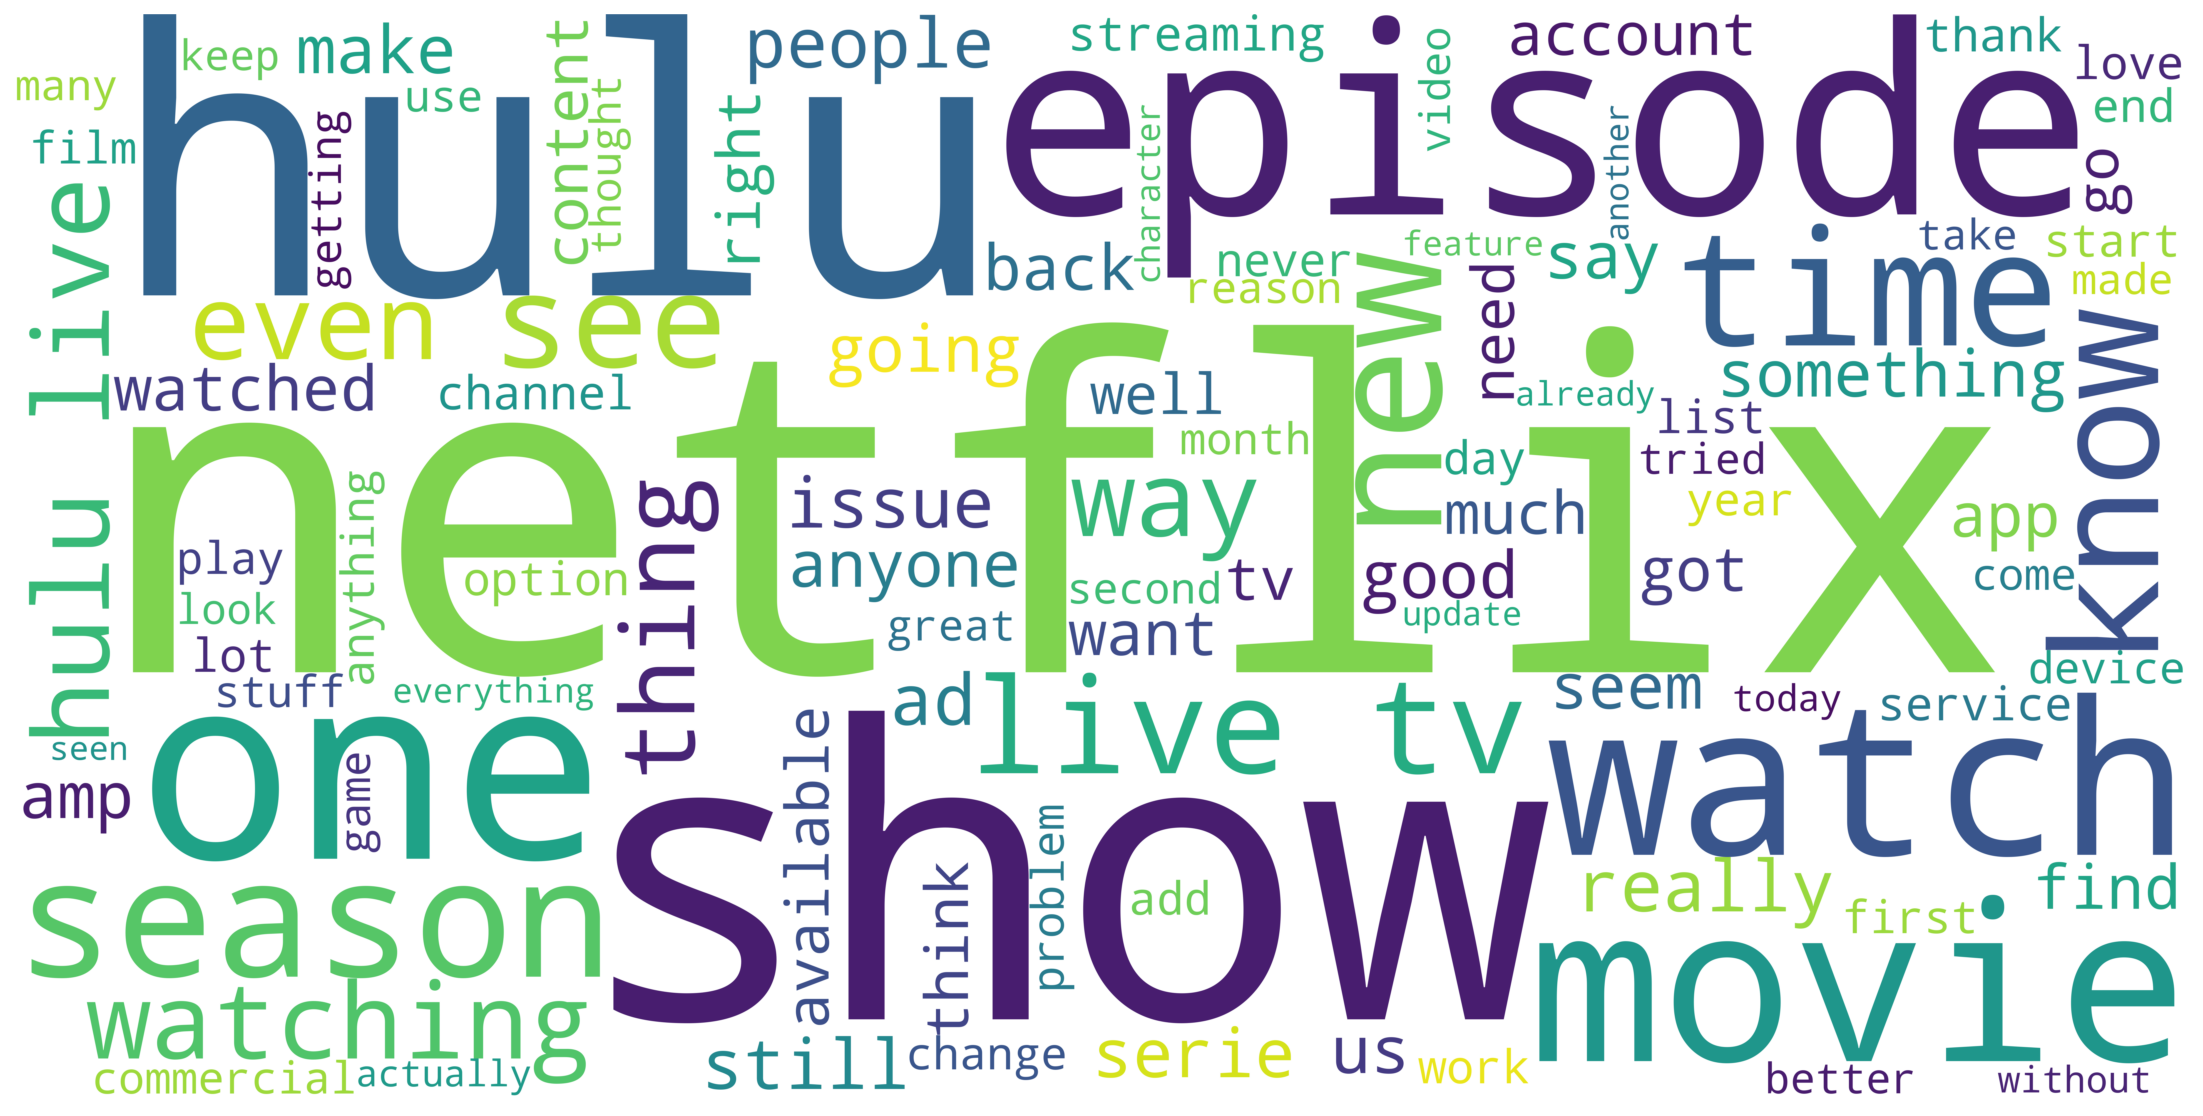

In [412]:
#Creating a word cloud to map out all common words in the dataset (where the larger font 
#indicates a higher frequency)
text = " ".join(review for review in subreddit_df.all_txt)
# Create and generate a word cloud image:
wordcloud = WordCloud(width=10000, height=5000, background_color="white", max_words=100).generate(text)

# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

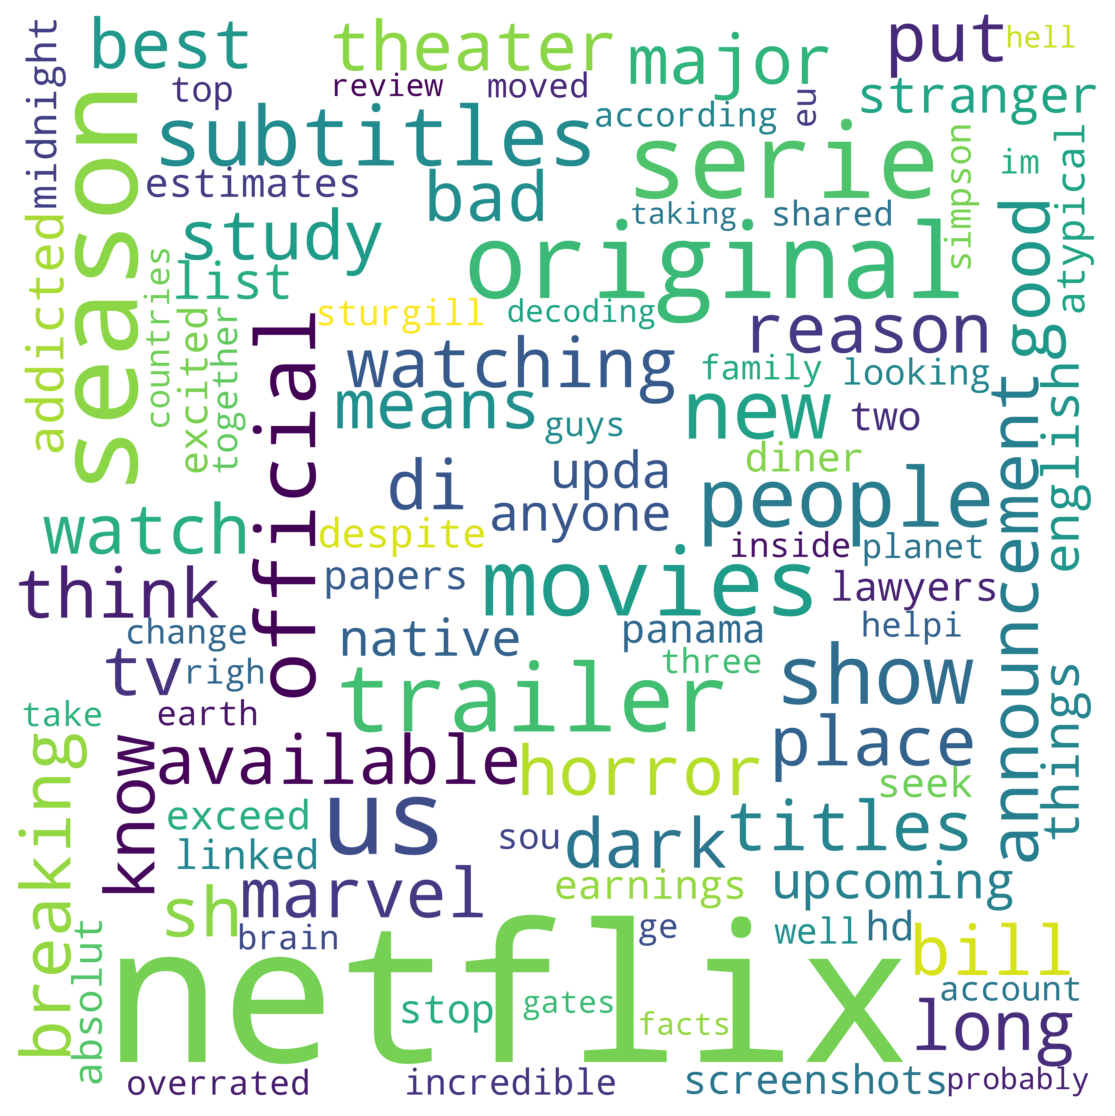

In [413]:
# Create and generate a word cloud image:
wordcloud = WordCloud(width=5000, height=5000, background_color="white", max_words=100).generate(str(subreddit_df.all_txt[subreddit_df.subreddit == 1]))

# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

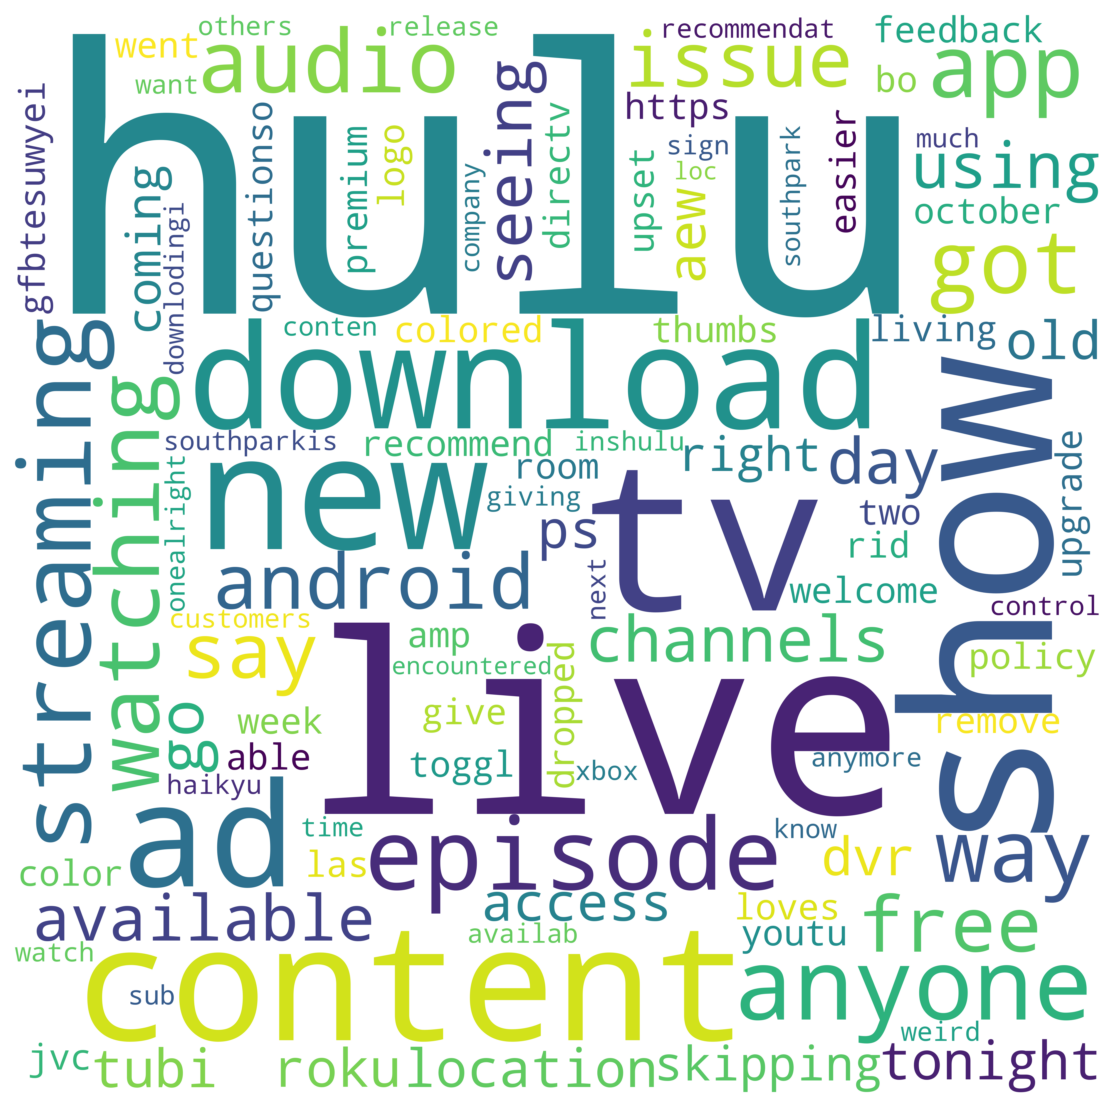

In [414]:
# Create and generate a word cloud image:
wordcloud = WordCloud(width=5000, height=5000, background_color="white", max_words=100).generate(str(subreddit_df.all_txt[subreddit_df.subreddit == 0]))

# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Count Vectorizer

In [415]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
cvec = CountVectorizer(analyzer = "word",
                             tokenizer = None,  #removed the LemmaTokenizer as it resulted in a poorer performing model
                             preprocessor = None,
                              max_features = 3000, ngram_range = (1,3)) #chosen an ngram of 3 as most show titles tend 
                                                                        #to consist of 2-3 words
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [416]:
X_train_df_cvec = pd.DataFrame(X_train_cvec.toarray(), columns = cvec.get_feature_names())
print(X_train_df_cvec.shape)
X_train_df_cvec.head()

(5577, 3000)


,abc,ability,able,able get,able see,able use,able watch,absolutely,academy,accept,access,access hulu,accidentally,according,account,accounts,across,act,acting,action,active,actively,actor,actors,actual,actually,ad,ad free,adam,adaptation,add,add ons,added,added hulu,added hulu probably,adding,addition,additional,address,adds,admit,ads,ads hulu,ads live,ads plan,adult,adult swim,adults,advance,adventure,adventures,adventures sabrina,advertisement,advertisements,advertising,advice,affiliate,age,age resistance,agent,ago,agree,ahead,air,aired,airing,airs,alert,algorithm,allow,allowed,allowing,allows,almost,almost every,alone,along,alot,already,already seen,already watched,also,also place,also place ask,altered,altered carbon,alternative,although,always,always sunny,always sunny philadelphia,ama,amazing,amazon,amazon fire,amazon prime,amc,america,american,american dad,american horror,american horror story,among,amount,amp,amp amp,amp edit,amp https,amp thanks,amp utm,amp utm medium,amy,amy schumer,android,android app,android tv,animated,animation,anime,announced,announcement,announcements,announcements new,announcements new shows,announces,annoyed,annoying,another,another life,answer,answers,anybody,anybody else,anybody know,anymore,anyone,anyone else,anyone else experiencing,anyone else issue,anyone else issues,anyone else problem,anyone help,anyone know,anything,anything else,anytime,anyway,anywhere,apart,app,apparently,appear,appears,apple,apple tv,appletv,application,appreciate,appreciated,appropriate,appropriate use,appropriate use gt,apps,apps becomes,apps becomes problem,april,archer,area,around,arrested,art,article,articles,asian,aside,ask,ask give,ask give recommendations,ask recommendations,ask recommendations watch,asked,asked place,asked place discussion,asking,asleep,ass,assume,attached,attack,attempt,attention,audience,audio,august,australia,auto,auto play,automatically,autoplay,autoplaying,availability,available,available hulu,available netflix,avatar,avoid,avoid confusion,avoid confusion sure,avoid spoilers,avoid spoilers use,avoid using,avoid using spoilers,aware,away,awesome,awesome idea,awesome idea shows,awful,back,back hulu,back old,background,bad,bad movie,ball,bandersnatch,bandwidth,bank,bar,barely,base,based,basic,basically,basis,bbc,beautiful,become,becomes,becomes problem,becomes problem look,becoming,bed,begin,beginning,begins,behind,believe,ben,besides,...,updating,upgrade,upgraded,upgrading,upon,upset,us,us netflix,usa,use,use gt,use gt text,use hulu,use netflix,use reddit,use reddit spoiler,used,useful,useless,user,username,users,uses,using,using hulu,using netflix,using spoilers,using spoilers possible,usual,usually,utm,utm medium,utm source,vacation,vader,vader father,vader father lt,value,variety,various,version,version hulu,versions,via,via moderator,via moderator mail,video,video quality,videos,videos trailers,videos trailers posts,view,viewed,viewer,viewers,viewing,viewing history,vikings,violent,vision,visit,vizio,vod,voice,voices,volume,vote,votes,vpn,vs,vue,wait,waiting,walking,walking dead,wanna,want,want briefly,want briefly discuss,want get,want know,want make,want see,want watch,wanted,wanted watch,wanting,wants,war,warning,wars,watch,watch anything,watch episode,watch game,watch hulu,watch hulu hulu,watch hulu subreddit,watch list,watch live,watch movie,watch netflix,watch new,watch next,watch one,watch please,watch please great,watch show,watch shows,watch something,watch tv,watch want,watch want briefly,watched,watched first,watches,watching,watching episode,watching hulu,watching hulu week,watching live,watching movie,watching netflix,watching recommend,watching recommend hulu,watching season,watching show,watching shows,watching something,watching think,watching think feel,watchlist,way,way better,way get,way make,way watch,ways,web,web browser,website,week,week shows,week shows movies,weekend,weekly,weekly show,weekly show movie,weeks,weeks ago,weight,weird,welcome,welcome hulu,welco

In [417]:
X_test_df_cvec =pd.DataFrame(X_test_cvec.toarray(),columns = cvec.get_feature_names())
print(X_test_df_cvec.shape)
X_test_df_cvec.head()

(1860, 3000)


,abc,ability,able,able get,able see,able use,able watch,absolutely,academy,accept,access,access hulu,accidentally,according,account,accounts,across,act,acting,action,active,actively,actor,actors,actual,actually,ad,ad free,adam,adaptation,add,add ons,added,added hulu,added hulu probably,adding,addition,additional,address,adds,admit,ads,ads hulu,ads live,ads plan,adult,adult swim,adults,advance,adventure,adventures,adventures sabrina,advertisement,advertisements,advertising,advice,affiliate,age,age resistance,agent,ago,agree,ahead,air,aired,airing,airs,alert,algorithm,allow,allowed,allowing,allows,almost,almost every,alone,along,alot,already,already seen,already watched,also,also place,also place ask,altered,altered carbon,alternative,although,always,always sunny,always sunny philadelphia,ama,amazing,amazon,amazon fire,amazon prime,amc,america,american,american dad,american horror,american horror story,among,amount,amp,amp amp,amp edit,amp https,amp thanks,amp utm,amp utm medium,amy,amy schumer,android,android app,android tv,animated,animation,anime,announced,announcement,announcements,announcements new,announcements new shows,announces,annoyed,annoying,another,another life,answer,answers,anybody,anybody else,anybody know,anymore,anyone,anyone else,anyone else experiencing,anyone else issue,anyone else issues,anyone else problem,anyone help,anyone know,anything,anything else,anytime,anyway,anywhere,apart,app,apparently,appear,appears,apple,apple tv,appletv,application,appreciate,appreciated,appropriate,appropriate use,appropriate use gt,apps,apps becomes,apps becomes problem,april,archer,area,around,arrested,art,article,articles,asian,aside,ask,ask give,ask give recommendations,ask recommendations,ask recommendations watch,asked,asked place,asked place discussion,asking,asleep,ass,assume,attached,attack,attempt,attention,audience,audio,august,australia,auto,auto play,automatically,autoplay,autoplaying,availability,available,available hulu,available netflix,avatar,avoid,avoid confusion,avoid confusion sure,avoid spoilers,avoid spoilers use,avoid using,avoid using spoilers,aware,away,awesome,awesome idea,awesome idea shows,awful,back,back hulu,back old,background,bad,bad movie,ball,bandersnatch,bandwidth,bank,bar,barely,base,based,basic,basically,basis,bbc,beautiful,become,becomes,becomes problem,becomes problem look,becoming,bed,begin,beginning,begins,behind,believe,ben,besides,...,updating,upgrade,upgraded,upgrading,upon,upset,us,us netflix,usa,use,use gt,use gt text,use hulu,use netflix,use reddit,use reddit spoiler,used,useful,useless,user,username,users,uses,using,using hulu,using netflix,using spoilers,using spoilers possible,usual,usually,utm,utm medium,utm source,vacation,vader,vader father,vader father lt,value,variety,various,version,version hulu,versions,via,via moderator,via moderator mail,video,video quality,videos,videos trailers,videos trailers posts,view,viewed,viewer,viewers,viewing,viewing history,vikings,violent,vision,visit,vizio,vod,voice,voices,volume,vote,votes,vpn,vs,vue,wait,waiting,walking,walking dead,wanna,want,want briefly,want briefly discuss,want get,want know,want make,want see,want watch,wanted,wanted watch,wanting,wants,war,warning,wars,watch,watch anything,watch episode,watch game,watch hulu,watch hulu hulu,watch hulu subreddit,watch list,watch live,watch movie,watch netflix,watch new,watch next,watch one,watch please,watch please great,watch show,watch shows,watch something,watch tv,watch want,watch want briefly,watched,watched first,watches,watching,watching episode,watching hulu,watching hulu week,watching live,watching movie,watching netflix,watching recommend,watching recommend hulu,watching season,watching show,watching shows,watching something,watching think,watching think feel,watchlist,way,way better,way get,way make,way watch,ways,web,web browser,website,week,week shows,week shows movies,weekend,weekly,weekly show,weekly show movie,weeks,weeks ago,weight,weird,welcome,welcome hulu,welco

In [418]:
netflix_cvec = pd.DataFrame(X_train_cvec.todense(), 
                          columns=cvec.get_feature_names()).reindex(y_train[y_train == 1].index)
top_netflix = netflix_cvec.mean().sort_values(ascending=False).iloc[:10]
top_netflix.values

array([0.71824104, 0.68241042, 0.31009772, 0.30521173, 0.29348534,
       0.28957655, 0.27687296, 0.21693811, 0.19576547, 0.19413681])

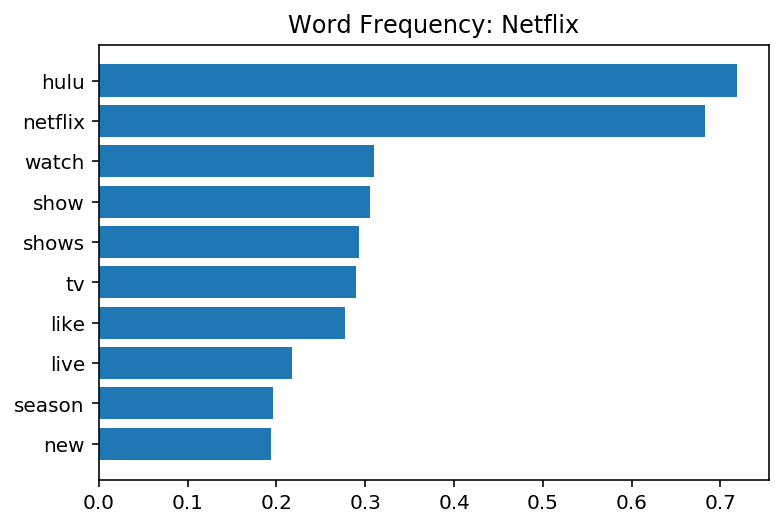

In [419]:
top_netflix = top_netflix.sort_values(ascending=True)
plt.barh(top_netflix.index, top_netflix.values)
plt.title('Word Frequency: Netflix');

Surprisingly the word 'hulu' appears quite frequently in the Netflix dataset, and at a higher frequency than 'Netflix'. There are certain words that could have been filtered out through WordNetLemmatizer method such as 'show' and 'shows' however that method had actually returned a poorer result through my iterative process (probably as it had wrongly changed a few important words) and hence I have chosen not to lemmatize my bag of words.

In [420]:
hulu_cvec = pd.DataFrame(X_train_cvec.todense(), 
                          columns=cvec.get_feature_names()).reindex(y_train[y_train == 0].index)
top_hulu = hulu_cvec.mean().sort_values(ascending=False).iloc[:10]
top_hulu.values

array([0.7325476 , 0.61468722, 0.32728921, 0.31731641, 0.3118767 ,
       0.24297371, 0.22937443, 0.19129646, 0.18495014, 0.16772439])

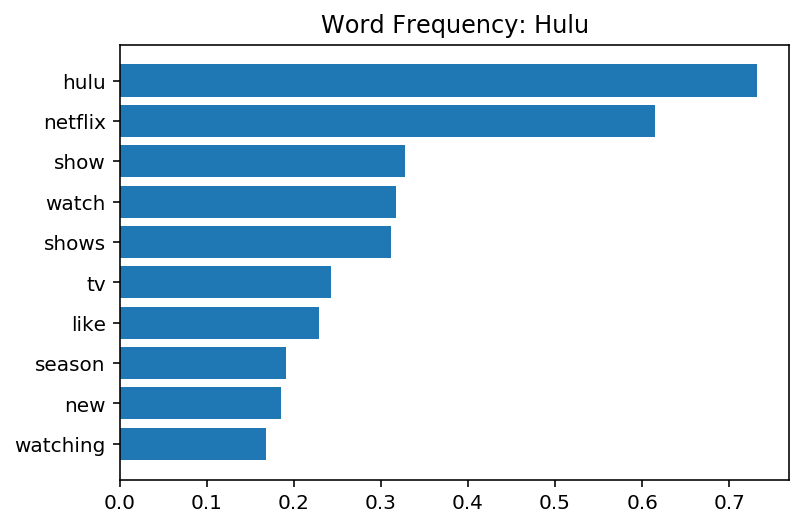

In [421]:
top_hulu = top_hulu.sort_values(ascending=True)
plt.barh(top_hulu.index, top_hulu.values)
plt.title('Word Frequency: Hulu');

There is still quite a high frequency of the word 'Netflix' in the hulu dataset that was expected. Top 10 words also are quite similar to the Netflix set e.g. show, watch, shows, tv, like. While these words are frequent in both datasets, this also means they are unlikely to be meaningful determinants when trying to classify posts.

#### TFIDF Vectorizer

In [422]:
#Fitting a TF-IDF Vectorizer

tvec = TfidfVectorizer(analyzer = "word",
                             tokenizer = None, #Similarly, removed LemmaTokenizer as it made the model poorer
                             preprocessor = None,
                             max_features=3000,ngram_range=(1,3)) 

X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)
X_train_tvec

<5577x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 140531 stored elements in Compressed Sparse Row format>

In [423]:
X_train_df_tvec = pd.DataFrame(X_train_tvec.toarray(), columns = tvec.get_feature_names())
print(X_train_df_tvec.shape)
X_train_df_tvec.head()

(5577, 3000)


,abc,ability,able,able get,able see,able use,able watch,absolutely,academy,accept,access,access hulu,accidentally,according,account,accounts,across,act,acting,action,active,actively,actor,actors,actual,actually,ad,ad free,adam,adaptation,add,add ons,added,added hulu,added hulu probably,adding,addition,additional,address,adds,admit,ads,ads hulu,ads live,ads plan,adult,adult swim,adults,advance,adventure,adventures,adventures sabrina,advertisement,advertisements,advertising,advice,affiliate,age,age resistance,agent,ago,agree,ahead,air,aired,airing,airs,alert,algorithm,allow,allowed,allowing,allows,almost,almost every,alone,along,alot,already,already seen,already watched,also,also place,also place ask,altered,altered carbon,alternative,although,always,always sunny,always sunny philadelphia,ama,amazing,amazon,amazon fire,amazon prime,amc,america,american,american dad,american horror,american horror story,among,amount,amp,amp amp,amp edit,amp https,amp thanks,amp utm,amp utm medium,amy,amy schumer,android,android app,android tv,animated,animation,anime,announced,announcement,announcements,announcements new,announcements new shows,announces,annoyed,annoying,another,another life,answer,answers,anybody,anybody else,anybody know,anymore,anyone,anyone else,anyone else experiencing,anyone else issue,anyone else issues,anyone else problem,anyone help,anyone know,anything,anything else,anytime,anyway,anywhere,apart,app,apparently,appear,appears,apple,apple tv,appletv,application,appreciate,appreciated,appropriate,appropriate use,appropriate use gt,apps,apps becomes,apps becomes problem,april,archer,area,around,arrested,art,article,articles,asian,aside,ask,ask give,ask give recommendations,ask recommendations,ask recommendations watch,asked,asked place,asked place discussion,asking,asleep,ass,assume,attached,attack,attempt,attention,audience,audio,august,australia,auto,auto play,automatically,autoplay,autoplaying,availability,available,available hulu,available netflix,avatar,avoid,avoid confusion,avoid confusion sure,avoid spoilers,avoid spoilers use,avoid using,avoid using spoilers,aware,away,awesome,awesome idea,awesome idea shows,awful,back,back hulu,back old,background,bad,bad movie,ball,bandersnatch,bandwidth,bank,bar,barely,base,based,basic,basically,basis,bbc,beautiful,become,becomes,becomes problem,becomes problem look,becoming,bed,begin,beginning,begins,behind,believe,ben,besides,...,updating,upgrade,upgraded,upgrading,upon,upset,us,us netflix,usa,use,use gt,use gt text,use hulu,use netflix,use reddit,use reddit spoiler,used,useful,useless,user,username,users,uses,using,using hulu,using netflix,using spoilers,using spoilers possible,usual,usually,utm,utm medium,utm source,vacation,vader,vader father,vader father lt,value,variety,various,version,version hulu,versions,via,via moderator,via moderator mail,video,video quality,videos,videos trailers,videos trailers posts,view,viewed,viewer,viewers,viewing,viewing history,vikings,violent,vision,visit,vizio,vod,voice,voices,volume,vote,votes,vpn,vs,vue,wait,waiting,walking,walking dead,wanna,want,want briefly,want briefly discuss,want get,want know,want make,want see,want watch,wanted,wanted watch,wanting,wants,war,warning,wars,watch,watch anything,watch episode,watch game,watch hulu,watch hulu hulu,watch hulu subreddit,watch list,watch live,watch movie,watch netflix,watch new,watch next,watch one,watch please,watch please great,watch show,watch shows,watch something,watch tv,watch want,watch want briefly,watched,watched first,watches,watching,watching episode,watching hulu,watching hulu week,watching live,watching movie,watching netflix,watching recommend,watching recommend hulu,watching season,watching show,watching shows,watching something,watching think,watching think feel,watchlist,way,way better,way get,way make,way watch,ways,web,web browser,website,week,week shows,week shows movies,weekend,weekly,weekly show,weekly show movie,weeks,weeks ago,weight,weird,welcome,welcome hulu,welco

In [424]:
X_test_df_tvec =pd.DataFrame(X_test_tvec.toarray(),columns = tvec.get_feature_names())
X_test_df_tvec.head()

,abc,ability,able,able get,able see,able use,able watch,absolutely,academy,accept,access,access hulu,accidentally,according,account,accounts,across,act,acting,action,active,actively,actor,actors,actual,actually,ad,ad free,adam,adaptation,add,add ons,added,added hulu,added hulu probably,adding,addition,additional,address,adds,admit,ads,ads hulu,ads live,ads plan,adult,adult swim,adults,advance,adventure,adventures,adventures sabrina,advertisement,advertisements,advertising,advice,affiliate,age,age resistance,agent,ago,agree,ahead,air,aired,airing,airs,alert,algorithm,allow,allowed,allowing,allows,almost,almost every,alone,along,alot,already,already seen,already watched,also,also place,also place ask,altered,altered carbon,alternative,although,always,always sunny,always sunny philadelphia,ama,amazing,amazon,amazon fire,amazon prime,amc,america,american,american dad,american horror,american horror story,among,amount,amp,amp amp,amp edit,amp https,amp thanks,amp utm,amp utm medium,amy,amy schumer,android,android app,android tv,animated,animation,anime,announced,announcement,announcements,announcements new,announcements new shows,announces,annoyed,annoying,another,another life,answer,answers,anybody,anybody else,anybody know,anymore,anyone,anyone else,anyone else experiencing,anyone else issue,anyone else issues,anyone else problem,anyone help,anyone know,anything,anything else,anytime,anyway,anywhere,apart,app,apparently,appear,appears,apple,apple tv,appletv,application,appreciate,appreciated,appropriate,appropriate use,appropriate use gt,apps,apps becomes,apps becomes problem,april,archer,area,around,arrested,art,article,articles,asian,aside,ask,ask give,ask give recommendations,ask recommendations,ask recommendations watch,asked,asked place,asked place discussion,asking,asleep,ass,assume,attached,attack,attempt,attention,audience,audio,august,australia,auto,auto play,automatically,autoplay,autoplaying,availability,available,available hulu,available netflix,avatar,avoid,avoid confusion,avoid confusion sure,avoid spoilers,avoid spoilers use,avoid using,avoid using spoilers,aware,away,awesome,awesome idea,awesome idea shows,awful,back,back hulu,back old,background,bad,bad movie,ball,bandersnatch,bandwidth,bank,bar,barely,base,based,basic,basically,basis,bbc,beautiful,become,becomes,becomes problem,becomes problem look,becoming,bed,begin,beginning,begins,behind,believe,ben,besides,...,updating,upgrade,upgraded,upgrading,upon,upset,us,us netflix,usa,use,use gt,use gt text,use hulu,use netflix,use reddit,use reddit spoiler,used,useful,useless,user,username,users,uses,using,using hulu,using netflix,using spoilers,using spoilers possible,usual,usually,utm,utm medium,utm source,vacation,vader,vader father,vader father lt,value,variety,various,version,version hulu,versions,via,via moderator,via moderator mail,video,video quality,videos,videos trailers,videos trailers posts,view,viewed,viewer,viewers,viewing,viewing history,vikings,violent,vision,visit,vizio,vod,voice,voices,volume,vote,votes,vpn,vs,vue,wait,waiting,walking,walking dead,wanna,want,want briefly,want briefly discuss,want get,want know,want make,want see,want watch,wanted,wanted watch,wanting,wants,war,warning,wars,watch,watch anything,watch episode,watch game,watch hulu,watch hulu hulu,watch hulu subreddit,watch list,watch live,watch movie,watch netflix,watch new,watch next,watch one,watch please,watch please great,watch show,watch shows,watch something,watch tv,watch want,watch want briefly,watched,watched first,watches,watching,watching episode,watching hulu,watching hulu week,watching live,watching movie,watching netflix,watching recommend,watching recommend hulu,watching season,watching show,watching shows,watching something,watching think,watching think feel,watchlist,way,way better,way get,way make,way watch,ways,web,web browser,website,week,week shows,week shows movies,weekend,weekly,weekly show,weekly show movie,weeks,weeks ago,weight,weird,welcome,welcome hulu,welco

In [425]:
netflix_tvec = pd.DataFrame(X_train_tvec.todense(), 
                          columns=tvec.get_feature_names()).reindex(y_train[y_train == 1].index)
top_netflix2 = netflix_tvec.mean().sort_values(ascending=False).iloc[:10]
top_netflix2.values

array([0.05310945, 0.04816278, 0.02295856, 0.02289242, 0.02217123,
       0.02160413, 0.02142118, 0.01981177, 0.01922922, 0.01856746])

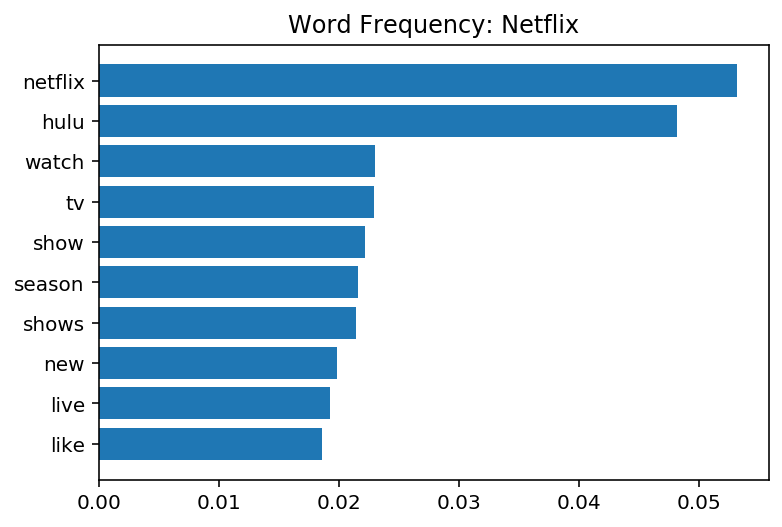

In [426]:
top_netflix2 = top_netflix2.sort_values(ascending=True)
plt.barh(top_netflix2.index, top_netflix2.values)
plt.title('Word Frequency: Netflix');

Using the TF-IFD vectorizer, for the Netflix dataset, the word 'netflix' has a higher frequency than hulu which is what we expect. Most of the words listed here are similar to when we use the CVEC vectorizer, however some of these words still seem to be part of the less informative words, which I had expected the vectorizer to filter out slightly.

In [427]:
hulu_tvec = pd.DataFrame(X_train_tvec.todense(), 
                          columns=tvec.get_feature_names()).reindex(y_train[y_train == 0].index)
top_hulu2 = hulu_tvec.mean().sort_values(ascending=False).iloc[:10]
top_hulu2.values

array([0.0524264 , 0.04808768, 0.02485036, 0.02458209, 0.0224293 ,
       0.0215123 , 0.01920193, 0.01838899, 0.01765084, 0.01666661])

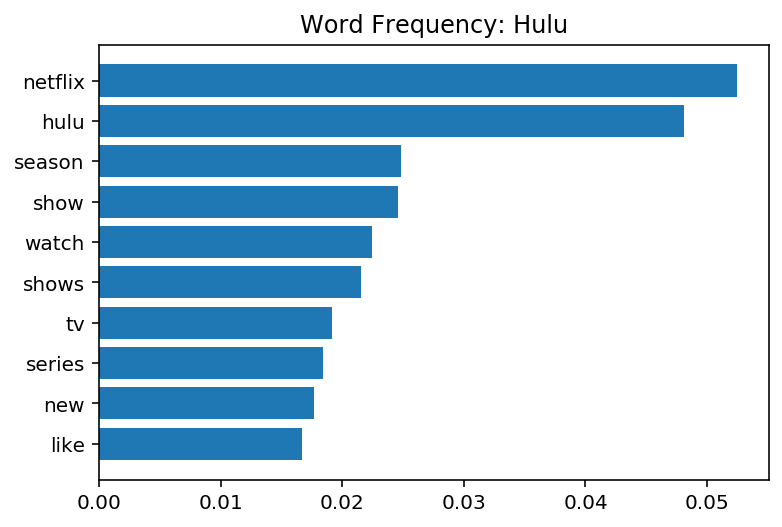

In [428]:
top_hulu2 = top_hulu2.sort_values(ascending=True)
plt.barh(top_hulu2.index, top_hulu2.values)
plt.title('Word Frequency: Hulu');

The TFIFD Vectorizer seems to be performing better than CVEC as for both datasets, the most frequent word is the name of the dataset we are trying to predict (e.g. 'netflix' for Netflix dataset, and 'hulu' for Hulu dataset. 

#### Hashing Vectorizer

In [429]:
hvec = HashingVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                        alternate_sign=False) 
X_train_hvec = hvec.fit_transform(X_train)
X_test_hvec = hvec.transform(X_test)
X_train_hvec

<5577x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 144763 stored elements in Compressed Sparse Row format>

Including a hashing vectorizer to see if it performs better than the Count Vectorizer and TFIFD Vectorizer.

## Fitting Models

In [430]:
#Fitting a basic logistic regression model
lr = LogisticRegression()
lr.fit(X_train_cvec, y_train)

results = list()
result_1 = {'name':'Logistic Regression','feature set' : 'CountVectorizer','train score': lr.score(X_train_cvec, y_train), 
            'test score': lr.score(X_test_cvec, y_test)}
results.append(result_1)
pd.DataFrame(results)


/Users/lynn/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,feature set,name,test score,train score
0,CountVectorizer,Logistic Regression,0.922043,0.987986


In [431]:
def plot_coef(model,feature_type, top_n = 10):
    '''
    Plots the magnitude of top and bottom n coefficients
    '''
    feature_names = feature_type.get_feature_names()
    feature_coef = list(model.coef_[0])
    feature_df = pd.DataFrame([feature_names, feature_coefs]).T.sort_values(by = 1, ascending=True)
    top_10 = feature_df.head(top_n)
    bottom_10 = feature_df.tail(top_n)
    return pd.concat([top_10, bottom_10], axis=0).plot.barh(x = 0, y = 1,figsize=(10,6))

In [432]:
feature_names = cvec.get_feature_names()
feature_coefs = list(lr.coef_[0])
feature_df = pd.DataFrame([feature_names, feature_coefs]).T.sort_values(by = 1, ascending=False)
print(feature_df.head(10))
print(feature_df.tail(10))


                     0        1
1683           netflix  3.93629
2756                us  1.88929
2221  season available  1.46716
605               damn  1.39764
2929           witcher  1.35195
1081             group  1.16748
2145            review  1.16679
222                bad  1.15066
2478   stranger things  1.09671
1586        mindhunter  1.09612
                 0        1
409       channels -1.09123
2136          rest -1.11297
499    commercials  -1.1152
2311       showing -1.13677
731            dvr -1.21539
408        channel   -1.226
1437          live -1.25497
1412  like netflix -1.27204
2564          tale  -1.9099
1195          hulu -5.03125


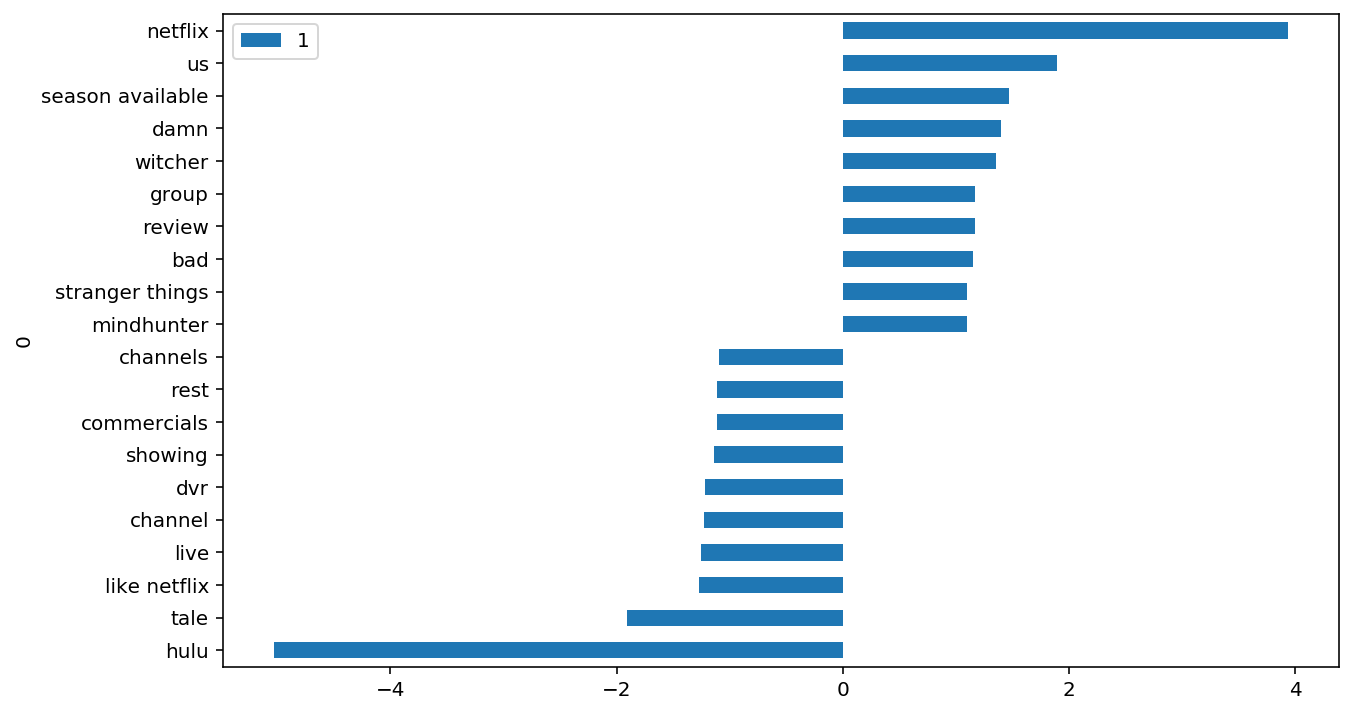

In [433]:
plot_coef(lr,cvec)

The logistic regression does a good job at picking up the important features from the bag of words. Apart from the word 'netflix', the words with a positive coefficient (and hence sways the result more towards Netflix) are titles of Netflix show (e.g. Mindhunter, Stranger Things, The Witcher). 

The word 'dvr' is important as Hulu offers a Cloud DVR to record TV shows to be watched at a later time which Netflix does not currently offer. As expected, the word 'tale' and 'live' is seen as Hulu's most popular shows are The Handmaid's Tale and Saturday Night Live. (For reference: https://www.hulu.com/start/content)

The score of 98% for training set and 92% for the testing set is pretty good however suggests that there may be some slight overfitting.

In [434]:
lr.fit(X_train_tvec, y_train)

result_2 = {'name':'Logistic Regression','feature set' : 'TF-IFD Vectorizer','train score': lr.score(X_train_tvec, y_train), 
            'test score': lr.score(X_test_tvec, y_test)}
results.append(result_2)
pd.DataFrame(results)

/Users/lynn/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,feature set,name,test score,train score
0,CountVectorizer,Logistic Regression,0.922043,0.987986
1,TF-IFD Vectorizer,Logistic Regression,0.930645,0.965394


In [435]:
feature_names = tvec.get_feature_names()
feature_coefs = list(lr.coef_[0])
feature_df = pd.DataFrame([feature_names, feature_coefs]).T.sort_values(by = 1, ascending=False)
print(feature_df.head(10))
print(feature_df.tail(10))


                     0        1
1683           netflix   13.576
2756                us  3.07074
1869            people  1.63989
2221  season available  1.61389
2052            really  1.59369
2478   stranger things  1.57629
1635             movie  1.54454
2668           trailer  1.52552
2474             story  1.51649
2477          stranger  1.51536
                0        1
1442      live tv -1.74766
496    commercial -1.76192
409      channels  -1.8125
408       channel -1.83345
2699           tv -2.08541
499   commercials -2.16043
731           dvr -2.19755
41            ads -2.34143
1437         live -3.25439
1195         hulu -16.1952


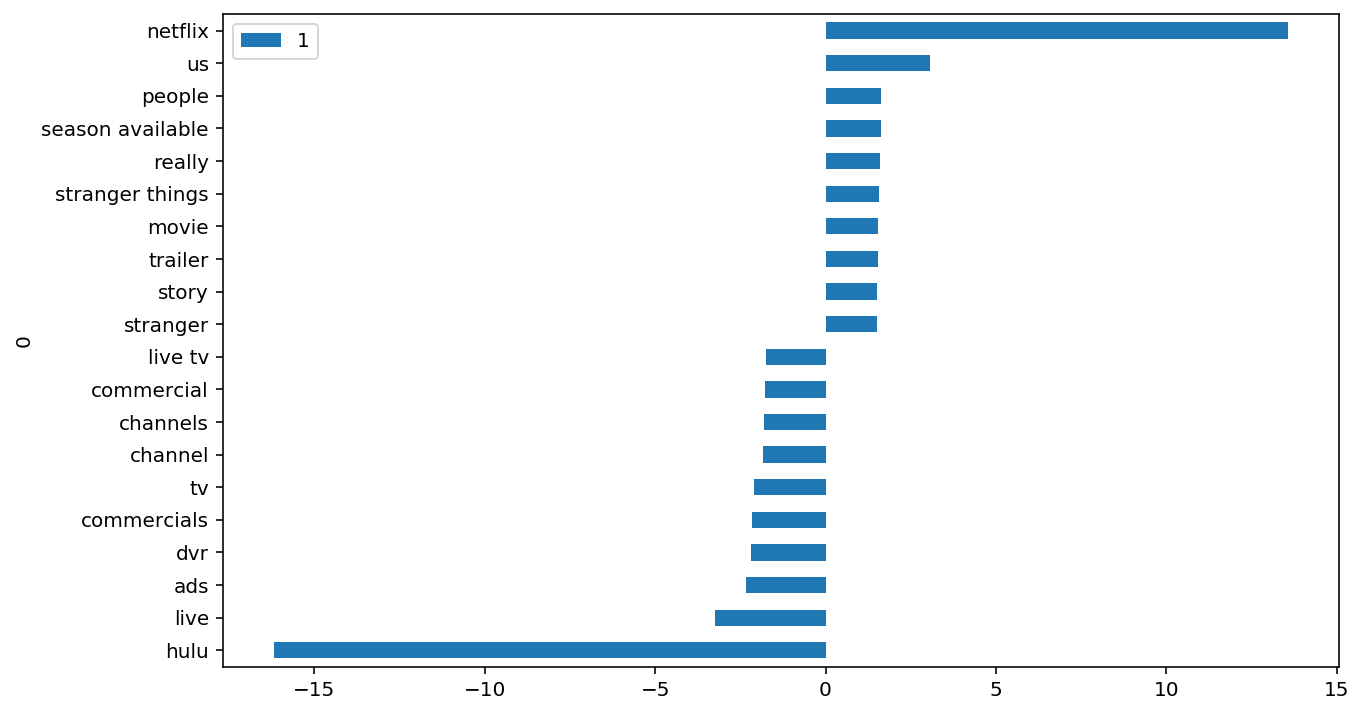

In [436]:
plot_coef(lr,tvec)

In [437]:
top_predictors = feature_df.reindex(feature_df[1].abs().sort_values(ascending=False).index)[:10]
top_predictors

,0,1
1195,hulu,-16.1952
1683,netflix,13.576
1437,live,-3.25439
2756,us,3.07074
41,ads,-2.34143
731,dvr,-2.19755
499,commercials,-2.16043
2699,tv,-2.08541
408,channel,-1.83345
409,channels,-1.8125


In [438]:
y_pred = lr.predict(X_test_tvec)
accuracy_score(y_test, y_pred) #verify that this is the same as lr.score above

0.9306451612903226

In [439]:
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(data=cm, columns=['pred. Netflix', 'pred. Hulu'],index=['act. Netflix', 'act. Hulu'])
confusion_matrix_df

,pred. Netflix,pred. Hulu
act. Netflix,710,92
act. Hulu,37,1021


With the TF-IFD vectorizer, Hulu and Netflix are assigned a higher coefficient than in the CVEC method as they are deemed to be the strongest features. Hulu has a higher coefficient as the word 'netflix' had a higher frequency in the hulu bag-of-words using the TFIFD vectorizer as we saw just now and the higher coefficient would balance that out. 

The predictors of Netflix is still largely made of popular netflix titles, including 'us' for 'When They See Us' which had garnered up to 23 million views in June (https://screenrant.com/when-they-see-us-viewers-ratings-netflix/) and hence expected to be a key topic point in Reddit. 

It seems that the word 'tale' which was the second most important determinant under the CVEC method for Hulu has dropped off under the TFIFD vectorizer, however the key features that sway the results towards Hulu are as before, less of titles but more of distinct characteristics offered by Hulu such as paid commercials/ads for advertisers to slot in between long format videos (https://www.google.com/search?q=hulu+commercial&oq=hulu+commercial&aqs=chrome..69i57l2j69i59l2j69i60l2.1790j0j7&sourceid=chrome&ie=UTF-8) - which Netflix does not currently have. Another feature that the model had picked up is Hulu's Live TV channel offering ('channel') (https://www.hulu.com/live-tv) which clearly distinguishes it to the likes of other streaming services including Netflix which offers only a streaming service for its library of content.


The training set had scored 97% and test set 93% which shows that overfitting had been reduced and is quite a good result for the model.

In [440]:
lr.fit(X_train_hvec, y_train)

result_3 = {'name':'Logistic Regression','feature set' : 'Hashing Vectorizer','train score': lr.score(X_train_hvec, y_train), 
            'test score': lr.score(X_test_hvec, y_test)}
results.append(result_3)
pd.DataFrame(results)


/Users/lynn/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,feature set,name,test score,train score
0,CountVectorizer,Logistic Regression,0.922043,0.987986
1,TF-IFD Vectorizer,Logistic Regression,0.930645,0.965394
2,Hashing Vectorizer,Logistic Regression,0.932258,0.962704


In [441]:
X_train_hvec.shape

(5577, 1048576)

The Hashing Vectorizer actually performed best with the Logistic Regression, however the features that have allowed for better prediction cannot be accessed. The results are marginally close to that of the TF-IFD Vectorizer and hence we will stick with the TF-IFD as we would like to know what are the key features of each dataset.

### Naive Bayes

In [442]:
from sklearn.naive_bayes import MultinomialNB

In [443]:
nb = MultinomialNB()


In [444]:
model_cvec = nb.fit(X_train_cvec, y_train)
result_4 = {'name':'Multinomial NB','feature set' : 'Count Vectorizer','train score': model_cvec.score(X_train_cvec,y_train), 
            'test score': model_cvec.score(X_test_cvec,y_test)}
results.append(result_4)
pd.DataFrame(results)


,feature set,name,test score,train score
0,CountVectorizer,Logistic Regression,0.922043,0.987986
1,TF-IFD Vectorizer,Logistic Regression,0.930645,0.965394
2,Hashing Vectorizer,Logistic Regression,0.932258,0.962704
3,Count Vectorizer,Multinomial NB,0.893011,0.921822


In [445]:
predictions_cvec = model_cvec.predict(X_test_cvec)

In [446]:
cm_nb_cvec = confusion_matrix(y_test, predictions_cvec)
confusion_matrix_df_nb_cvec = pd.DataFrame(data=cm_nb_cvec, columns=['pred. Netflix', 'pred. Hulu'],index=['act. Netflix', 'act. Hulu'])
confusion_matrix_df_nb_cvec

,pred. Netflix,pred. Hulu
act. Netflix,641,161
act. Hulu,38,1020


In [447]:
hulufeatures_df = pd.DataFrame([cvec.get_feature_names(),model_cvec.feature_log_prob_[0, :]]).T.sort_values(by = 1, ascending=False)
netflixfeatures_df = pd.DataFrame([cvec.get_feature_names(),model_cvec.feature_log_prob_[1, :]]).T.sort_values(by = 1, ascending=False)

print(hulufeatures_df.head(10))
print(netflixfeatures_df.head(10))

            0        1
1195     hulu -3.16659
2699       tv -4.37207
1437     live -4.46387
2841    watch -4.58338
2313    shows -4.61057
2293     show  -4.8625
1408     like -5.09661
1723      new -5.16437
1442  live tv -5.17178
1025      get -5.20389
             0        1
1683   netflix -3.24446
2293      show  -4.4916
1408      like -4.62498
2220    season -4.76693
2841     watch -4.83697
2313     shows -4.83982
1799       one -5.08241
2266    series -5.17772
1723       new -5.19385
2866  watching -5.22901


In [448]:
model_tvec = nb.fit(X_train_tvec, y_train)
result_5 = {'name':'Multinomial NB','feature set' : 'TF-IFD Vectorizer','train score': model_tvec.score(X_train_tvec,y_train), 
            'test score': model_tvec.score(X_test_tvec,y_test)}
results.append(result_5)
pd.DataFrame(results)


,feature set,name,test score,train score
0,CountVectorizer,Logistic Regression,0.922043,0.987986
1,TF-IFD Vectorizer,Logistic Regression,0.930645,0.965394
2,Hashing Vectorizer,Logistic Regression,0.932258,0.962704
3,Count Vectorizer,Multinomial NB,0.893011,0.921822
4,TF-IFD Vectorizer,Multinomial NB,0.881183,0.921642


In [449]:
predictions_tvec = model_tvec.predict(X_test_tvec)

In [450]:
cm_nb_tvec = confusion_matrix(y_test, predictions_tvec)
confusion_matrix_df_nb_tvec = pd.DataFrame(data=cm_nb_tvec, columns=['pred. Netflix', 'pred. Hulu'],index=['act. Netflix', 'act. Hulu'])
confusion_matrix_df_nb_tvec

,pred. Netflix,pred. Hulu
act. Netflix,672,130
act. Hulu,91,967


In [451]:
hulufeatures_df = pd.DataFrame([tvec.get_feature_names(),model_tvec.feature_log_prob_[0, :]]).T.sort_values(by = 1, ascending=False)
netflixfeatures_df = pd.DataFrame([tvec.get_feature_names(),model_tvec.feature_log_prob_[1, :]]).T.sort_values(by = 1, ascending=False)

print(hulufeatures_df.head(10))
print(netflixfeatures_df.head(10))

              0        1
1195       hulu -3.92652
1437       live -4.94252
2699         tv  -4.9704
2841      watch -5.28049
2313      shows -5.36728
2293       show -5.50777
135      anyone -5.53969
1211  hulu live -5.54459
1442    live tv -5.55501
1723        new -5.59542
            0        1
1683  netflix   -3.955
2220   season -5.11303
2293     show  -5.2767
2266   series -5.46237
1408     like -5.48639
2756       us -5.50737
2313    shows -5.56527
1635    movie -5.57121
1723      new -5.59879
2841    watch -5.61145


In [452]:
model_hvec = nb.fit(X_train_hvec, y_train)
result_6 = {'name':'Multinomial NB','feature set' : 'Hashing Vectorizer','train score': model_hvec.score(X_train_hvec,y_train), 
            'test score': model_cvec.score(X_test_hvec,y_test)}
results.append(result_6)
pd.DataFrame(results)

,feature set,name,test score,train score
0,CountVectorizer,Logistic Regression,0.922043,0.987986
1,TF-IFD Vectorizer,Logistic Regression,0.930645,0.965394
2,Hashing Vectorizer,Logistic Regression,0.932258,0.962704
3,Count Vectorizer,Multinomial NB,0.893011,0.921822
4,TF-IFD Vectorizer,Multinomial NB,0.881183,0.921642
5,Hashing Vectorizer,Multinomial NB,0.909677,0.944056


Compared to the Logistic Regression models, MultinomialNB performs poorly and doesn't achieve as high an accuracy level (Average of 89% when compared to LR's average of 93% accuracy). Looking at the coefficients of the MultinomialNB models, it seems the largest predictor of it being Netflix or Hulu is the mention of the words 'netflix' and 'hulu' respectively, and the rest of the words having a fairly low probability of being able to predict. The words with the higher probabilities are also seemingly insignificant as they give no real insights as to the type of data (e.g. show, series, like, movie could be referring to either dataset) and hence are probably lousy predictors. This may be why the Logistic Regression model works better as the coefficients with a higher assigned value are insightful features.

### Random Forest 

In [453]:
rf = RandomForestClassifier(n_estimators=175, max_features = 4)

In [454]:
cross_val_score(rf, X_train_tvec, y_train, cv=5).mean()

0.930605943713133

In [455]:
rf_params = {
    "n_estimators" :[150,175,200],
    "max_depth" :[None,1,5]
}
gs = GridSearchCV(rf, param_grid = rf_params, cv=5)

In [456]:
gs.fit(X_train_tvec, y_train)
print(gs.best_score_)
print(gs.best_params_)
print(gs.score(X_train_tvec,y_train))
print(gs.score(X_test_tvec,y_test))

0.9316837009144702
{'max_depth': None, 'n_estimators': 175}
0.9976689976689976
0.9166666666666666


In [457]:
result_7 = {'name':'Random Forest','feature set' : 'TF-IFD','train score': gs.score(X_train_tvec,y_train), 
            'test score': gs.score(X_test_tvec,y_test)}
results.append(result_7)

In [458]:
gs.fit(X_train_cvec, y_train)
print(gs.best_score_)
print(gs.best_params_)
print(gs.score(X_train_cvec,y_train))
print(gs.score(X_test_cvec,y_test))

0.9266630805092344
{'max_depth': None, 'n_estimators': 200}
0.9976689976689976
0.9150537634408602


In [459]:
result_8 = {'name':'Random Forest','feature set' : 'Count Vectorizer','train score': gs.score(X_train_cvec,y_train), 
            'test score': gs.score(X_test_cvec,y_test)}
results.append(result_8)

In [460]:
pd.DataFrame(results)

,feature set,name,test score,train score
0,CountVectorizer,Logistic Regression,0.922043,0.987986
1,TF-IFD Vectorizer,Logistic Regression,0.930645,0.965394
2,Hashing Vectorizer,Logistic Regression,0.932258,0.962704
3,Count Vectorizer,Multinomial NB,0.893011,0.921822
4,TF-IFD Vectorizer,Multinomial NB,0.881183,0.921642
5,Hashing Vectorizer,Multinomial NB,0.909677,0.944056
6,TF-IFD,Random Forest,0.916667,0.997669
7,Count Vectorizer,Random Forest,0.915054,0.997669


Random Forest models are not a good predictor as they tend to overfit the data (high train score but low test score) and hence is not a good model to classify the subreddits.

### Final Model Selection

Given that the TFIFD Vectorizer and Logistic Regression has performed the best (apart from the Hashing Vectorizer - however I choose not to select this model as I would like to understand which features are the most important), this model has been selected as the final model.  

/Users/lynn/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


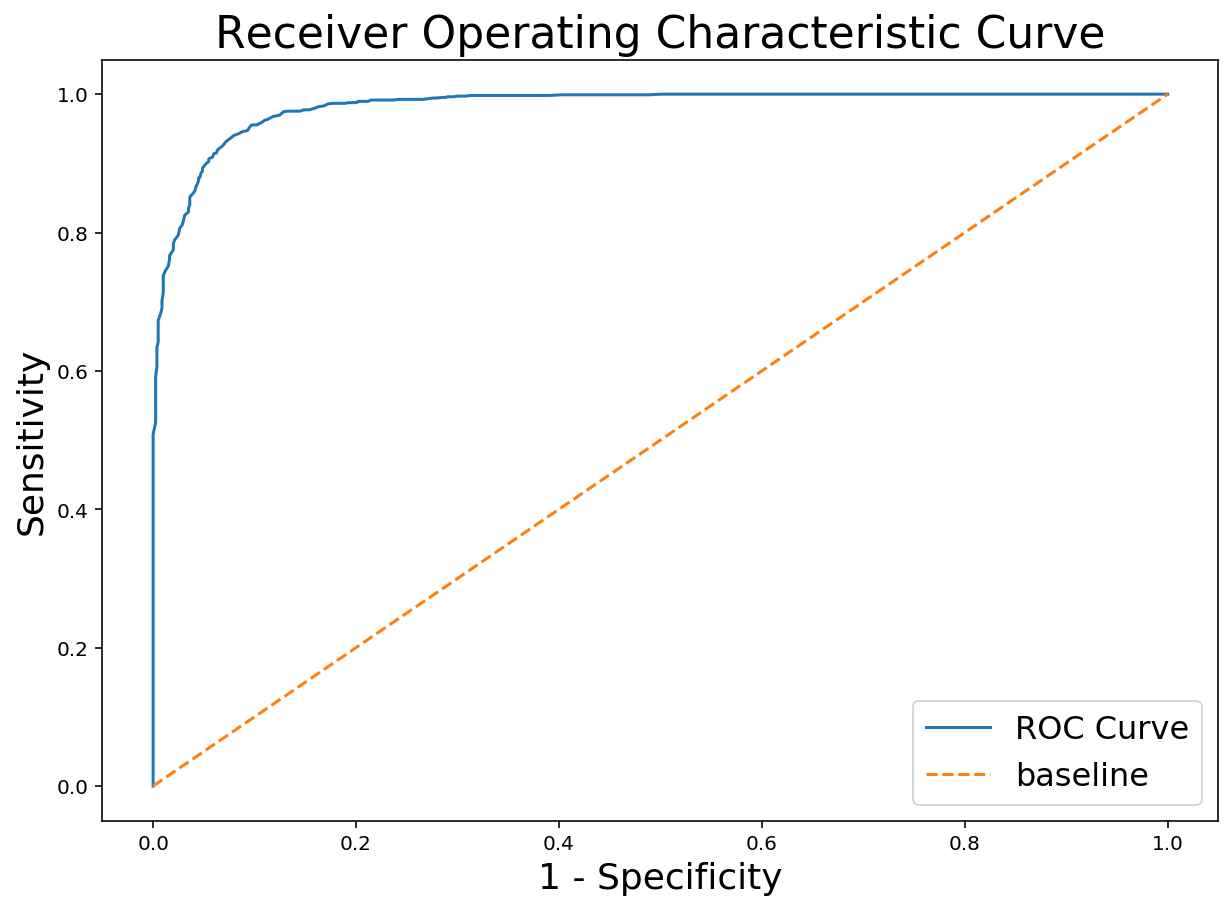

In [461]:
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)
lr.fit(X_train_tvec, y_train)

pred_proba = [i[1] for i in lr.predict_proba(X_test_tvec)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [462]:
from sklearn.metrics import roc_auc_score
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.9822118852207855

A high ROC AUC score indicates that the negative and positive values are well separated and the TFIFD and Logistic Regression is working very well!

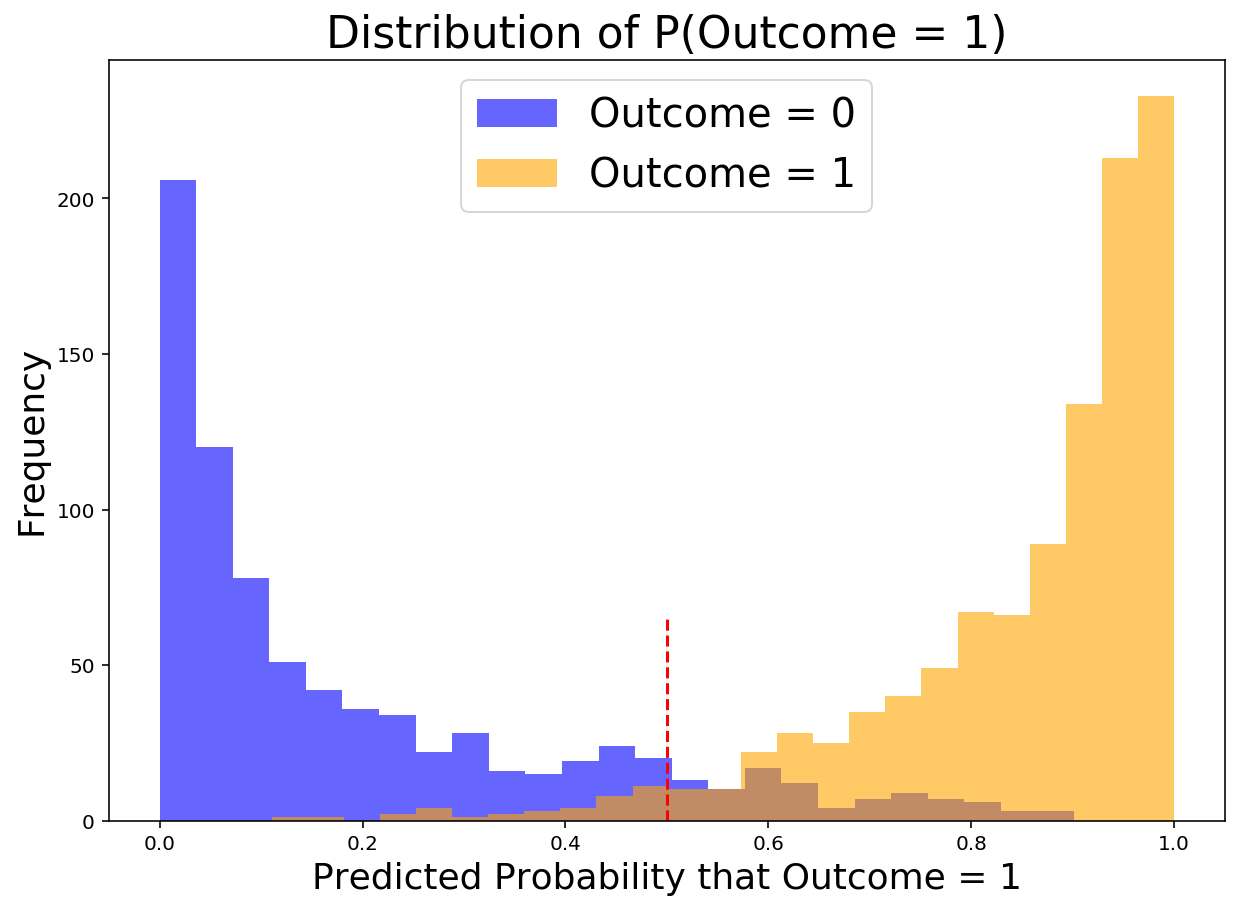

In [463]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

Blue and orange are roughly balanced (with slightly tending towards 1, which is Netflix) which is expected given the larger data set (~55% vs 45%) but there is little overlap between the two datasets which means that accuracy of the model is low. The orange portion that is to the left of the red line indicates posts that the model has incorrectly predicted to be Hulu posts (false negative) and the blue portions to the right of the red lines are false negatives, e.g. posts that have been predicted to be Netflix posts but are actually Hulu posts.

## Testing out the model on other datasets

In [464]:
#Preparing the dataframes
makeup = pd.read_csv('makeup.csv')  #importing MakeUpAddiction data
skincare = pd.read_csv('skincare.csv') #importing SkinCareAddition data

/Users/lynn/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (24,30,57,93) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/lynn/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [465]:
makeup['selftext'].fillna('', inplace=True) #fills empty cells with a space to allow concatenation in the next step
makeup['all_txt'] = makeup['title']+makeup['selftext'] # joining together two columns for analysis
makeup['all_txt'].isnull().sum() #ensuring there is no null values

0

In [466]:
skincare['selftext'].fillna('', inplace=True) #fills empty cells with a space to allow concatenation in the next step
skincare['all_txt'] = skincare['title']+skincare['selftext'] # joining together two columns for analysis
skincare['all_txt'].isnull().sum() #ensuring there is no null values

0

In [467]:
makeup['subreddit'].head()

0    MakeupAddiction
1    MakeupAddiction
2    MakeupAddiction
3    MakeupAddiction
4    MakeupAddiction
Name: subreddit, dtype: object

In [468]:
#Assigning 1 and 0 to makeup threads and skincare threads respectively by replacing the words in the 'subreddit column' in both DataFrames
makeup['subreddit'].replace(to_replace='MakeupAddiction', value=1, inplace=True)
skincare['subreddit'].replace(to_replace='SkincareAddiction', value=0, inplace=True)

#Joining the two DataFrames together
joint_df = pd.concat(objs=(makeup,skincare), axis=0, ignore_index=True)

#Final DataFrame to only include the texts and target values
subreddit2_df = joint_df.loc[:, ['all_txt', 'subreddit']]


/Users/lynn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [469]:
subreddit2_df['all_txt'] = subreddit2_df['all_txt'].apply(post_to_words)

In [470]:
subreddit2_df.to_csv('subreddit2_txt.csv')

In [471]:
subreddit2_df.head()

,all_txt,subreddit
0,recent changes rule post review flair daily di...,1
1,daily discussion simple questions selfie sunda...,1
2,client pic ccw help improve ask anything vegas...,1
3,loving dewy natural skin peachy tones moment,1
4,blue bronze cut crease,1


In [472]:
subreddit2_df['subreddit'].value_counts()/subreddit2_df.shape[0]

0    0.51591
1    0.48409
Name: subreddit, dtype: float64

Dataset for both Make Up and Skincare are balanced. This will be the baseline accuracy for this dataset.

In [473]:
X = subreddit2_df['all_txt']
y = subreddit2_df['subreddit'] 

In [474]:
#Performing a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25) 

In [475]:
#using the same vectorizer that we have chosen for our final model
tvec = TfidfVectorizer(analyzer = "word",
                             tokenizer = None, 
                             preprocessor = None,
                             max_features=3000,ngram_range=(1,3)) 

X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)
X_train_tvec

<13599x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 379561 stored elements in Compressed Sparse Row format>

In [476]:
lr.fit(X_train_tvec, y_train)

print('The train score for thbis dataset is ' + str(lr.score(X_train_tvec, y_train)))
print('The test score for this dataset is ' + str(lr.score(X_test_tvec, y_test)))


The train score for thbis dataset is 0.9891168468269725
The test score for this dataset is 0.9819144243493604


/Users/lynn/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [477]:
feature_names = tvec.get_feature_names()
feature_coefs = list(lr.coef_[0])
feature_df = pd.DataFrame([feature_names, feature_coefs]).T.sort_values(by = 1, ascending=False)
print(feature_df.head(10))
print(feature_df.tail(10))


               0        1
1479      makeup  6.48281
352          ccw  4.67991
1429        look  4.59158
932   foundation  4.51855
1776     palette  3.98434
815    eyeshadow   2.7517
813     eyeliner  2.74441
1404    lipstick  2.67249
1072   halloween   2.3636
2253       shade  2.18307
                     0        1
2355          skincare -5.07989
1090              haul -5.14451
1944  product question -5.91518
1976               psa -6.11879
2268           shelfie -6.20282
2136           routine  -6.3873
13                acne -7.86707
2302              skin -8.44799
1203             humor -8.81433
1553              misc -9.06124


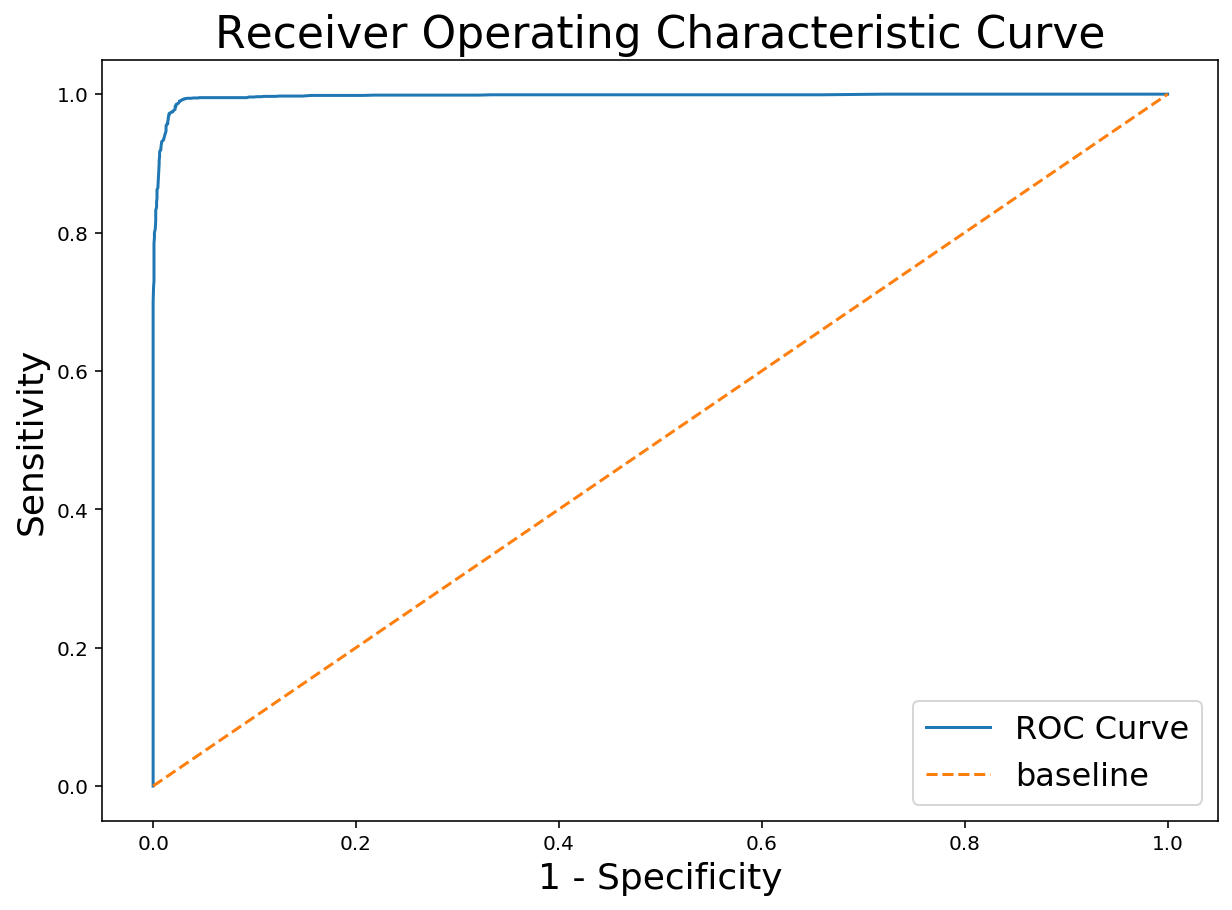

In [478]:
pred_proba = [i[1] for i in lr.predict_proba(X_test_tvec)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [479]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.9969764466646984

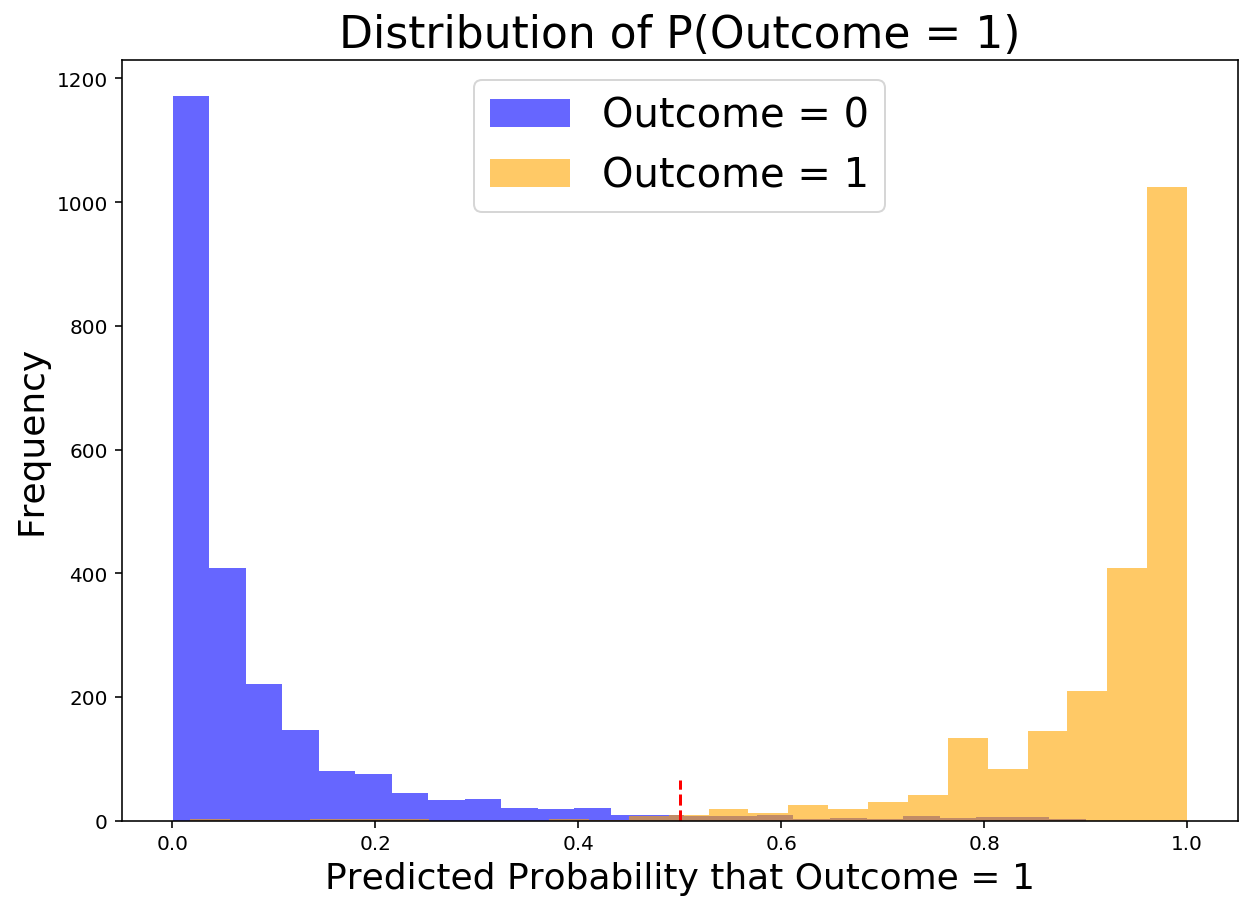

In [480]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

The model operated better than it did on the original Netflix-Hulu dataset, achieving a train and test score of 98.9% and 98.1%. As we can see in the distribution of probability graph above, there is also little overlap in the middle, which indicates a high level of accuracy. Unlike the Netflix-Hulu dataset, a rebi-gram word was actually one of the key features for Skincare.

### Conclusion

The model chosen works well to classify subreddits, not only that of Netflix and Hulu, but other subreddits where the syntax is generally quite close too. I had initially expected the accuracy score to be quite low given the similarities but the Logistic Regression together with a TFIFD vectorizer which allows up to 3 combined words (which will then capture popular title names for the streaming devices/OTT dataset, but didn't really matter when it came to the makeup and skincare dataset).

The model had also managed to capture the key differences in the OTT dataset, which shows through the key features of each dataset, where Netflix comments were differentiated through the titles offered, and Hulu through its features (e.g. commercials, live TV, channels, ability to connect to DVR).